In [1]:
!pip install  pptk

import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors 
import os                       # Built-in library for filesystem access etc.
import pickle                   # For (re)storing Python objects into (from) files 
import time                     # For measuring time
import torch
from torchvision import datasets
from torchvision import io
from torchvision import models
from torchvision import ops
from torchvision import transforms
from torchvision import utils
from PIL import Image
from google.colab import drive
import pptk
import sklearn
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#https://github.com/dtczhl/dtc-KITTI-For-Beginners
drive.mount('/content/drive',force_remount=True)
path_to_point_cloud = '/content/drive/MyDrive/000020.bin'
point_cloud_data = np.fromfile(path_to_point_cloud, '<f4')  # little-endian float32
point_cloud_data = np.reshape(point_cloud_data, (-1, 4))    # x, y, z, r
#pptk.viewer(point_cloud_data[:, :3])
point_cloud_data.shape

Mounted at /content/drive


(126456, 4)

In [3]:
#GPU 
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


In [4]:
# feature extraction done with PCA 

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(point_cloud_data)
X_train_std = sc.transform(point_cloud_data)
X_test_std = sc.transform(point_cloud_data)
from sklearn.decomposition import PCA

pca = sklearn.decomposition.PCA(n_components=4)
pca.fit(X_train_std)
V = pca.components_.T

In [5]:
import torch.nn.functional as F
class FeatureEmbedder(torch.nn.Module):
  def __init__(self , N ): # N is the total point size 
    super().__init__()
    # 1- PCA part  PCA is improvised for feature extraction 

    self.N = N
    self.S = 16 # 4 * 4 PCa  it can be 9 3*3 if you do not want to alser intensity

    self.T_size = 2 * N # it generates 2 d points 


    #iteration 1 
    self.iter1_fc1 = torch.nn.Linear(self.N * (self.S+4) , self.T_size )
    #iteration 2 
    self.iter2_fc2 = torch.nn.Linear(self.T_size  +  self.S  * self.N , self.T_size )
    #iteration3 
    self.iter3_fc3 = torch.nn.Linear(self.T_size  + self.S  * self.N , self.T_size )

  def forward(self,pca , point_cloud):
    # x is a pca  (4,4)
    pca = pca.reshape(16,1) # pca is now 16 to fit in one dimension
    print(pca.shape , pca)
    #now we have to duplicate the matrix N times where n is the number of points
    G = torch.tile(pca , (1 , self.N) ) # R e N * S+4
    G = G.T
    # embedding 1 
    print( "g " , G.shape , " point cloud "  , point_cloud.shape  )
    H1 = torch.concat( ( point_cloud  , G) , 1  )#now concat the point cloud
    print( H1.shape , " H1 ")

    T1 = F.sigmoid(self.iter1_fc1(H1.reshape( H1.shape[0] * H1.shape[1]) ))
    #rearrange to (2 , T1.size/2)
    T1 = T1.reshape( self.N , 2 )    
    T1 = torch.concat( ( T1 , G  ) , 1 )

    #second layer 
    T2 = F.sigmoid(self.iter2_fc2(T1.reshape( T1.shape[0] * T1.shape[1])))
    T2 = T2.reshape( self.N, 2 )    
    T2 = torch.concat( ( T2 , G ) ,1  )

    #second layer 
    T3 = F.sigmoid(self.iter3_fc3(T2.reshape( T2.shape[0] * T2.shape[1])))
    T3 = T3.reshape( self.N, 2 )    
    print("T3 shape " , T3.shape) # N x 2 
    
    return T3


    

                

In [6]:
def find_maximum_and_pad(data , maximum_size):
  empty_point = np.array([0,0,0,0])
  size = data[i].shape[0]
  points_needed = maximum_size - size
  if points_needed > 0:
    empty_points = np.tile(empty_point , (points_needed , 1))
    data = np.concatenate(data , empty_points)
  return data 

In [7]:
def customloss(points , N   , m ):
  D = 1 / (np.sqrt(m) - 1) # m is np.sqrt
  min_arr = torch.zeros((N , 2 ) )
  for i in range( len(points)):
    second_smallest = torch.kthvalue(( points[i,0] - points[:,0] ) ** 2 + ( points[i,1] - points[:,1] ) ** 2 , 2 )
    min_arr[i] = second_smallest.values
  #temp_arr = -1 * torch.log( min_arr.clone().detach() - D + 1) 
  temp_arr = torch.where( min_arr >= D , 0  , 1   )
  min_arr = -1 * torch.log( min_arr -D + 1)
  min_arr *= temp_arr
  print( min_arr)
  total_loss = torch.sum(min_arr) / N 
  #min_arr = -1 * torch.log( min_arr - D + 1 )
  #torch.where(condition = min_arr >= D ,  min_arr  = 0 ,   min_arr  =  -torch.log(min_arr - D +1 ))
  return total_loss

In [8]:
from sklearn.decomposition import PCA
import torch
N = 500
m = np.sqrt(N * 2) 
mock_data = torch.rand( ( N ,4 ))

pca = sklearn.decomposition.PCA(n_components=4)
pca.fit(mock_data)
mock_pca  = pca.components_.T

test = FeatureEmbedder(N)
T = test.forward(torch.FloatTensor(mock_pca) , torch.FloatTensor(mock_data) )
loss = customloss(T  , N , m)
loss.requires_grad = True 
loss.backward()

torch.Size([16, 1]) tensor([[ 0.4058],
        [-0.7096],
        [ 0.4721],
        [-0.3300],
        [ 0.5993],
        [ 0.5808],
        [-0.0268],
        [-0.5503],
        [ 0.5284],
        [-0.3170],
        [-0.7374],
        [ 0.2768],
        [-0.4438],
        [-0.2421],
        [-0.4825],
        [-0.7153]])
g  torch.Size([500, 16])  point cloud  torch.Size([500, 4])
torch.Size([500, 20])  H1 
T3 shape  torch.Size([500, 2])
tensor([[0.2437, 0.2437],
        [0.2437, 0.2437],
        [0.2437, 0.2437],
        [0.2436, 0.2436],
        [0.2437, 0.2437],
        [0.2436, 0.2436],
        [0.2437, 0.2437],
        [0.2437, 0.2437],
        [0.2436, 0.2436],
        [0.2435, 0.2435],
        [0.2436, 0.2436],
        [0.2433, 0.2433],
        [0.2437, 0.2437],
        [0.2437, 0.2437],
        [0.2437, 0.2437],
        [0.2437, 0.2437],
        [0.2437, 0.2437],
        [0.2437, 0.2437],
        [0.2437, 0.2437],
        [0.2437, 0.2437],
        [0.2435, 0.2435],
        [0.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


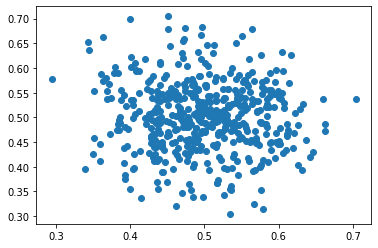

In [9]:
#poits before normalisation 
import matplotlib.pyplot as plt

plt.scatter(T[:,0].detach().numpy(), T[:,1].detach().numpy())

In [10]:
######################### Feature normalization module  #################################################
def create_grid(m , T ):
  max_x = (torch.max(T[:,0])).item()
  min_x = torch.min(T[:,0]).item()
  max_y = torch.max(T[:,1]).item()
  min_y = torch.min(T[:,1]).item()
  diff_x = max_x - min_x
  diff_y = max_y - min_y
  diff = max( diff_x , diff_y )
  print(diff_x)
  xgrid = np.linspace(min_x,min_x+diff,m)
  ygrid = np.linspace(min_y,min_y+diff,m)
  return torch.from_numpy(np.array(np.meshgrid(xgrid , ygrid )).T.reshape(-1,2))



def BallQueryNormalisation(point_cloud , T , r , m , grid ):
  q = torch.ones( (  grid.shape[0] , 4  ))
  print( grid.shape)
  for i in range(grid.shape[0]  ):
    distances = ( grid[i,0] - T[:,0] ) ** 2 + ( grid[i,1] - T[:,1] ) ** 2
    distances = torch.sqrt( distances)
    new_distances = distances <= r 
    new_points = T[ new_distances.nonzero() ] 
    new_points = new_points.reshape(new_points.shape[0] , new_points.shape[2] )
    new_point_cloud = point_cloud[new_distances.nonzero()]
    new_point_cloud = new_point_cloud.reshape(new_point_cloud.shape[0] , new_point_cloud.shape[2] )

    tiled_vi = torch.tile( grid[i] , ( new_points.shape[0] , 1  ))
    #print(  "tiled vi " ,  tiled_vi.shape , "new points " , new_points.shape  )
    qj = tiled_vi * new_points 
    qj = torch.sum(qj , 1 )
    #print( "qj shape "  ,  qj.shape  )
    vi_times_tj_sum = torch.sum(qj )
    qj /= vi_times_tj_sum
    #print( "qj shape "  ,  qj.shape  )
    qj = qj.unsqueeze(1)
    #print( qj.shape , " q j " , new_point_cloud.shape , "new point "  )
    q_i = torch.sum(  qj *   new_point_cloud  , 0  ) 
    #print( q_i )
    q[i] = q_i
  print("ballquerynormal" , q)
  return q
def BilinearInterpolationNormalisation(grid , T , point_cloud , k = 5  ):
  w = 1
  q = torch.zeros( (  grid.shape[0] , 4 ))
  for i in range( grid.shape[0]):
    distances = ( grid[i,0] - T[:,0] ) ** 2 + ( grid[i,1] - T[:,1] ) ** 2
    distances = torch.sqrt( distances)
    k_nearest_points_T_indices = distances.topk(k, largest=False).indices
    k_nearest_points_p = point_cloud[k_nearest_points_T_indices] 
    k_nearest_points_T = T[k_nearest_points_T_indices]
    distances = distances[k_nearest_points_T_indices] # distances of top k 
    #print( "distances " , distances )
    h = torch.exp( (-distances) / w )
    #print( "h " , h )
    h_sum = torch.sum(h)
    #print( "h  sum " , h_sum  )

    h = h / h_sum 
    #print( "h 2  " , h )

    #print( "h" , h.shape , "k_nearest_points " , k_nearest_points_p.shape )
    #print( "k_nearest_points_p"  ,k_nearest_points_p )
    h = h.unsqueeze(1)
    q_i = torch.sum( h * k_nearest_points_p , 0)
    #print( "qi " , q_i)
    #print( q_i.shape)
    q[i] = q_i 
  print("interpolation " , q)
  return q
m = 128
grid = create_grid( m , T )
point_cloud = torch.rand( ( T.shape[0] , 4 ))
r = 0.1 
q1 = BallQueryNormalisation(point_cloud, T , r  , m , grid )
print( "q1 shape " , q1.shape )
q2 = BilinearInterpolationNormalisation(grid , T  , point_cloud  )
print( "q2 shape " , q2.shape )
q_total = (q1 + q2) /2
print( q_total.shape) 
q_total

0.40978768467903137
torch.Size([16384, 2])
ballquerynormal tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.1938, 0.5462, 0.1388, 0.6030],
        [0.1938, 0.5462, 0.1388, 0.6030],
        ...,
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]], grad_fn=<CopySlices>)
q1 shape  torch.Size([16384, 4])
interpolation  tensor([[0.5432, 0.4794, 0.5692, 0.5356],
        [0.5430, 0.4793, 0.5692, 0.5356],
        [0.5428, 0.4793, 0.5692, 0.5356],
        ...,
        [0.5225, 0.7167, 0.6655, 0.7335],
        [0.5227, 0.7167, 0.6656, 0.7336],
        [0.5228, 0.7167, 0.6656, 0.7337]], grad_fn=<CopySlices>)
q2 shape  torch.Size([16384, 4])
torch.Size([16384, 4])


tensor([[0.2716, 0.2397, 0.2846, 0.2678],
        [0.3684, 0.5128, 0.3540, 0.5693],
        [0.3683, 0.5127, 0.3540, 0.5693],
        ...,
        [0.2613, 0.3584, 0.3327, 0.3668],
        [0.2613, 0.3584, 0.3328, 0.3668],
        [0.2614, 0.3584, 0.3328, 0.3668]], grad_fn=<DivBackward0>)

In [11]:
###################### Enforced Detection network #############################

class EnforcedDetector(torch.nn.Module ):
  def __init__(self , image ): # N is the total point size 
    super().__init__()
    # 1- PCA part  PCA is improvised for feature extraction 
    # image n x n 
    self.image = image #image is always 128*128*4
    
    #level 0 
    self.stdconv_0_0_1_0 = torch.nn.Conv2d(4 , 8 , 2 , stride = 2  ) #in 128 out 64

    self.stdconv_0_1_1_1 = torch.nn.Conv2d(8 , 8 , 2 , stride = 2 , padding =1   ) #in 126 out 64

    self.stdconv_0_2_1_2 = torch.nn.Conv2d(8 , 8 , 2 , stride = 2 , padding =2   ) #in 124 out 64

    self.stdconv_0_3_1_3 = torch.nn.Conv2d(8 , 8 , 2 , stride = 2 , padding =3   ) #in 122 out 64

    self.stdconv_0_4_1_4 = torch.nn.Conv2d(8 , 8 , 2 , stride = 2 , padding =4   ) #in 120 out 64



    self.convblock_0_0_0_1_3_3 = torch.nn.Conv2d(4 , 8 , 3, stride = 1   ) # in 128 # out 126
    self.convblock_0_0_0_1_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 126 # out 126

    self.convblock_0_1_0_2_3_3 = torch.nn.Conv2d(8 , 8 , 3, stride = 1   ) # in 126 # out 124
    self.convblock_0_1_0_2_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 124 # out 124

    self.convblock_0_2_0_3_3_3 = torch.nn.Conv2d(8 , 8 , 3, stride = 1   ) # in 124 # out 122
    self.convblock_0_2_0_3_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 122 # out 122

    self.convblock_0_3_0_4_3_3 = torch.nn.Conv2d(8 , 8 , 3, stride = 1   ) # in 122 # out 120
    self.convblock_0_3_0_4_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 120 # out 120


    self.maxpool = torch.nn.MaxPool2d(3, stride=1) # in 120 out 60 

    #level 1
    
    self.stdconv_1_0_2_0 = torch.nn.Conv2d(8 , 8 , 2 , stride = 2  ) # in 64 out 32 
    self.stdconv_1_1_2_1 = torch.nn.Conv2d(8 , 8 , 2 , stride = 2  ) # in 64 out 32 
    self.stdconv_1_2_2_2 = torch.nn.Conv2d(8 , 8 , 2 , stride = 2  ) # in 64 out 32 
    self.stdconv_1_3_2_3 = torch.nn.Conv2d(8 , 8 , 2 , stride = 2  ) # in 64 out 32 
    self.stdconv_1_4_2_4 = torch.nn.Conv2d(8 , 8 , 2 , stride = 2  ) # in 64 out 32 

    #conv blocks 
    self.convblock_1_0_1_1_3_3 = torch.nn.Conv2d(8 , 8 , 3, stride = 1 , padding = 1    ) # in 64  # out 64
    self.convblock_1_0_1_1_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 64 # out 64

    self.convblock_1_1_1_2_3_3 = torch.nn.Conv2d(8 , 8 , 3, stride = 1 , padding = 1    ) # in 64  # out 64
    self.convblock_1_1_1_2_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 64 # out 64

    self.convblock_1_2_1_3_3_3 = torch.nn.Conv2d(8 , 8 , 3, stride = 1 , padding = 1    ) # in 64  # out 64
    self.convblock_1_2_1_3_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 64 # out 64

    self.convblock_1_3_1_4_3_3 = torch.nn.Conv2d(8 , 8 , 3, stride = 1 , padding = 1    ) # in 64  # out 64
    self.convblock_1_3_1_4_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 64 # out 64
    #level 2 

    self.stdconv_2_0_3_0 = torch.nn.Conv2d(8 , 8 , 2 , stride = 2  ) # in 32  out 16 
    self.stdconv_2_1_3_1 = torch.nn.Conv2d(8 , 8 , 2 , stride = 2  ) # in 32  out 16 
    self.stdconv_2_2_3_2 = torch.nn.Conv2d(8 , 8 , 2 , stride = 2  ) # in 32  out 16 
    self.stdconv_2_3_3_3 = torch.nn.Conv2d(8 , 8 , 2 , stride = 2  ) # in 32  out 16 
    self.stdconv_2_4_3_4 = torch.nn.Conv2d(8 , 8 , 2 , stride = 2  ) # in 32  out 16 


    self.convblock_2_0_2_1_3_3 = torch.nn.Conv2d(8 , 8 , 3, stride = 1 , padding = 1    ) # in 32  # out 32
    self.convblock_2_0_2_1_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 32  # out 32

    self.convblock_2_1_2_2_3_3 = torch.nn.Conv2d(8 , 8 , 3, stride = 1 , padding = 1    ) # in 32  # out 32
    self.convblock_2_1_2_2_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 32  # out 32

    self.convblock_2_2_2_3_3_3 = torch.nn.Conv2d(8 , 8 , 3, stride = 1 , padding = 1    ) # in 32  # out 32
    self.convblock_2_2_2_3_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 32  # out 32

    self.convblock_2_3_2_4_3_3 = torch.nn.Conv2d(8 , 8 , 3, stride = 1 , padding = 1    ) # in 32  # out 32
    self.convblock_2_3_2_4_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 32  # out 32

    #level 3
    self.convblock_3_0_3_1_3_3 = torch.nn.Conv2d(8 , 8 , 3, stride = 1 , padding = 1    ) # in 16  # out 16
    self.convblock_3_0_3_1_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 16  # out 16

    self.convblock_3_1_3_2_3_3 = torch.nn.Conv2d(8 , 8 , 3, stride = 1 , padding = 1    ) # in 16  # out 16
    self.convblock_3_1_3_2_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 16  # out 16

    self.convblock_3_2_3_3_3_3 = torch.nn.Conv2d(8 , 8 , 3, stride = 1 , padding = 1    ) # in 16  # out 16
    self.convblock_3_2_3_3_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 16  # out 16

    self.convblock_3_3_3_4_3_3 = torch.nn.Conv2d(8 , 8 , 3, stride = 1 , padding = 1    ) # in 16  # out 16
    self.convblock_3_3_3_4_1_1 = torch.nn.Conv2d(8 , 8 , 1, stride = 1   ) # in 16  # out 16

  def forward( self , x ):
    # first strided convolutions 
    x_0_0_1_0 = self.stdconv_0_0_1_0(x)
    x_1_0_2_0 = self.stdconv_1_0_2_0(x_0_0_1_0)
    x_2_0_3_0 = self.stdconv_2_0_3_0(x_1_0_2_0)
    
    #first convolution blocks
    x_0_0_0_1 = self.convblock_0_0_0_1_3_3(x)
    x_0_0_0_1 = self.convblock_0_0_0_1_1_1(x_0_0_0_1)

    x_1_0_1_1 = self.convblock_1_0_1_1_3_3(x_0_0_1_0)
    x_1_0_1_1 = self.convblock_0_0_0_1_1_1(x_1_0_1_1)

    x_2_0_2_1 = self.convblock_2_0_2_1_3_3(x_1_0_2_0)
    x_2_0_2_1 = self.convblock_2_0_2_1_1_1(x_2_0_2_1)

    x_3_0_3_1 = self.convblock_3_0_3_1_3_3(x_2_0_3_0)
    x_3_0_3_1 = self.convblock_3_0_3_1_1_1(x_3_0_3_1)


    #calculating second layer 

    x_1_0_0_1 = torch.nn.functional.interpolate(x_0_0_1_0 , scale_factor = 126/64   )
    x_1_0_0_1 = x_1_0_0_1.permute( 0 , 2, 1 )
    x_1_0_0_1 = torch.nn.functional.interpolate(x_1_0_0_1 , scale_factor = 126/64   )
    x_1_0_0_1 = x_1_0_0_1.permute( 0 , 2, 1 )
    x_0_1 = x_1_0_0_1 + x_0_0_0_1

    # green
    x_2_0_1_1 = torch.nn.functional.interpolate(x_1_0_2_0 , scale_factor = 2   )
    x_2_0_1_1 = x_2_0_1_1.permute( 0 , 2, 1 )
    x_2_0_1_1 = torch.nn.functional.interpolate(x_2_0_1_1 , scale_factor = 2   )
    x_2_0_1_1 = x_2_0_1_1.permute( 0 , 2, 1 )

    #yellow 
    x_0_1_1_1 = self.stdconv_0_1_1_1(x_0_1)
    
    x_1_1 = x_2_0_1_1 +  x_0_1_1_1 + x_1_0_1_1


    #green
    x_3_0_2_1 = torch.nn.functional.interpolate(x_2_0_3_0 , scale_factor = 2  )
    x_3_0_2_1 = x_3_0_2_1.permute( 0 , 2, 1 )
    x_3_0_2_1 = torch.nn.functional.interpolate(x_3_0_2_1 , scale_factor = 2   )
    x_3_0_2_1 = x_3_0_2_1.permute( 0 , 2, 1 )
    
    #yellow 
    x_1_1_2_1 = self.stdconv_1_1_2_1(x_1_1)
    print( "x1121 " , x_1_1_2_1.shape )
    print( "asda " , x_2_0_2_1.shape )

    x_2_1 = x_3_0_2_1 + x_1_1_2_1 + x_2_0_2_1


    #
    x_3_1 = x_3_0_3_1 + self.stdconv_2_1_3_1(x_2_1)


    # third layer

    # 0 - 2 
    x_0_1_0_2 = self.convblock_0_1_0_2_3_3(x_0_1)
    x_0_1_0_2 = self.convblock_0_1_0_2_1_1(x_0_1_0_2)

    x_1_1_0_2 = torch.nn.functional.interpolate(x_1_1 , scale_factor = 124/64  )
    x_1_1_0_2 = x_1_1_0_2.permute( 0 , 2, 1 )
    x_1_1_0_2 = torch.nn.functional.interpolate(x_1_1_0_2 , scale_factor = 124/64   )
    x_1_1_0_2 = x_1_1_0_2.permute( 0 , 2, 1 )

    x_0_2 =  x_0_1_0_2 + x_1_1_0_2

    
    # 1 -2 
    x_1_1_1_2 = self.convblock_1_1_1_2_3_3(x_1_1)
    x_1_1_1_2 = self.convblock_1_1_1_2_1_1(x_1_1_1_2)

    x_0_2_1_2 = self.stdconv_0_2_1_2(x_0_2)

    x_2_1_1_2 = torch.nn.functional.interpolate(x_2_1 , scale_factor = 2 )
    x_2_1_1_2 = x_2_1_1_2.permute( 0 , 2, 1 )
    x_2_1_1_2 = torch.nn.functional.interpolate(x_2_1_1_2 , scale_factor = 2 )
    x_2_1_1_2 = x_2_1_1_2.permute( 0 , 2, 1 )

    x_1_2 = x_1_1_1_2 + x_0_2_1_2 + x_2_1_1_2

    # 2 -2 
    x_2_1_2_2 = self.convblock_2_1_2_2_3_3(x_2_1)
    x_2_1_2_2 = self.convblock_2_1_2_2_1_1(x_2_1)

    x_1_2_2_2 = self.stdconv_1_2_2_2(x_1_2)


    x_3_1_2_2 = torch.nn.functional.interpolate(x_3_1 , scale_factor = 2 )
    x_3_1_2_2 = x_3_1_2_2.permute( 0 , 2, 1 )
    x_3_1_2_2 = torch.nn.functional.interpolate(x_3_1_2_2 , scale_factor = 2 )
    x_3_1_2_2 = x_3_1_2_2.permute( 0 , 2, 1 )

    x_2_2 = x_2_1_2_2 + x_1_2_2_2 + x_3_1_2_2

    # 3 - 2 
    x_3_1_3_2 = self.convblock_3_1_3_2_3_3(x_3_1)
    x_3_1_3_2 = self.convblock_3_1_3_2_1_1(x_3_1_3_2)

    x_2_2_3_2 = self.stdconv_2_2_3_2(x_2_2)
    x_3_2 =  x_3_1_3_2 + x_2_2_3_2

    # 0 - 3 

    x_0_2_0_3 = self.convblock_0_2_0_3_3_3(x_0_2)
    x_0_2_0_3 = self.convblock_0_2_0_3_1_1(x_0_2_0_3)

    x_1_2_0_3 = torch.nn.functional.interpolate(x_1_2 , scale_factor = 122/64 )
    x_1_2_0_3 = x_1_2_0_3.permute( 0 , 2, 1 )
    x_1_2_0_3 = torch.nn.functional.interpolate(x_1_2_0_3 , scale_factor = 122/64 )
    x_1_2_0_3 = x_1_2_0_3.permute( 0 , 2, 1 )

    x_0_3 = x_0_2_0_3 + x_1_2_0_3

    # 1 - 3 

    x_1_2_1_3 = self.convblock_1_2_1_3_3_3(x_1_2)
    x_1_2_1_3 = self.convblock_1_2_1_3_1_1(x_1_2_1_3)

    x_0_3_1_3 = self.stdconv_0_3_1_3(x_0_3)

    x_2_2_1_3 = torch.nn.functional.interpolate(x_2_2 , scale_factor = 2 )
    x_2_2_1_3 = x_2_2_1_3.permute( 0 , 2, 1 )
    x_2_2_1_3 = torch.nn.functional.interpolate(x_2_2_1_3 , scale_factor = 2 )
    x_2_2_1_3 = x_2_2_1_3.permute( 0 , 2, 1 )

    x_1_3 = x_1_2_1_3 + x_0_3_1_3 + x_2_2_1_3

    # 2- 3 
    x_2_2_2_3 = self.convblock_2_2_2_3_3_3(x_2_2)
    x_2_2_2_3 = self.convblock_2_2_2_3_1_1(x_2_2_2_3)

    x_1_3_2_3 = self.stdconv_1_3_2_3(x_1_3)


    x_3_2_2_3 = torch.nn.functional.interpolate(x_3_2 , scale_factor = 2 )
    x_3_2_2_3 = x_3_2_2_3.permute( 0 , 2, 1 )
    x_3_2_2_3 = torch.nn.functional.interpolate(x_3_2_2_3 , scale_factor = 2 )
    x_3_2_2_3 = x_3_2_2_3.permute( 0 , 2, 1 )

    x_2_3 = x_2_2_2_3 + x_1_3_2_3 + x_3_2_2_3

    # 3- 3 
    x_3_2_3_3 = self.convblock_3_2_3_3_3_3(x_3_2)
    x_3_2_3_3 = self.convblock_3_2_3_3_1_1(x_3_2_3_3)

    x_2_3_3_3 = self.stdconv_2_3_3_3(x_2_3)
    x_3_3 =  x_3_2_3_3 + x_2_3_3_3

    # 0 -4 
    x_0_3_0_4 = self.convblock_0_3_0_4_3_3(x_0_3)
    x_0_3_0_4 = self.convblock_0_3_0_4_1_1(x_0_3_0_4)

    x_1_3_0_4 = torch.nn.functional.interpolate(x_1_3 , scale_factor = 120/64 )
    x_1_3_0_4 = x_1_3_0_4.permute( 0 , 2, 1 )
    x_1_3_0_4 = torch.nn.functional.interpolate(x_1_3_0_4 , scale_factor = 120/64 )
    x_1_3_0_4 = x_1_3_0_4.permute( 0 , 2, 1 )

    x_0_4 = x_1_3_0_4 + x_0_3_0_4

    # 1 - 4 
    x_1_3_1_4 = self.convblock_1_3_1_4_3_3(x_1_3)
    x_1_3_1_4 = self.convblock_1_3_1_4_1_1(x_1_3_1_4)

    x_0_4_1_4 = self.stdconv_0_4_1_4(x_0_4)

    x_2_3_1_4 = torch.nn.functional.interpolate(x_2_3 , scale_factor = 2 )
    x_2_3_1_4 = x_2_3_1_4.permute( 0 , 2, 1 )
    x_2_3_1_4 = torch.nn.functional.interpolate(x_2_3_1_4 , scale_factor = 2 )
    x_2_3_1_4 = x_2_3_1_4.permute( 0 , 2, 1 )

    x_1_4 = x_0_4_1_4 + x_1_3_1_4 + x_2_3_1_4

    # 2 - 4
    x_2_3_2_4 = self.convblock_2_3_2_4_3_3(x_2_3)
    x_2_3_2_4 = self.convblock_2_3_2_4_1_1(x_2_3_2_4)

    x_1_4_2_4 = self.stdconv_1_4_2_4(x_1_4)


    x_3_3_2_4 = torch.nn.functional.interpolate(x_3_3 , scale_factor = 2 )
    x_3_3_2_4 = x_3_3_2_4.permute( 0 , 2, 1 )
    x_3_3_2_4 = torch.nn.functional.interpolate(x_3_3_2_4 , scale_factor = 2 )
    x_3_3_2_4 = x_3_3_2_4.permute( 0 , 2, 1 )

    x_2_4 = x_2_3_2_4 + x_1_4_2_4 + x_3_3_2_4

    # 0 -5 
    x_max_pool = self.maxpool(x_0_4)

    x_1_4_0_5 = torch.nn.functional.interpolate(x_1_4 , scale_factor = 118/64 )
    x_1_4_0_5 = x_1_4_0_5.permute( 0 , 2, 1 )
    x_1_4_0_5 = torch.nn.functional.interpolate(x_1_4_0_5 , scale_factor = 118/64 )
    x_1_4_0_5 = x_1_4_0_5.permute( 0 , 2, 1 )

    x_0_5 = x_max_pool + x_1_4_0_5

    return (x_0_5  , x_1_4 , x_2_4  , x_3_3 )
s = EnforcedDetector(q_total)
print( q_total.shape)
q_total = torch.FloatTensor(q_total)
q_total = q_total.reshape( 4 , 128 , 128  )


s.forward(q_total)

torch.Size([16384, 4])
x1121  torch.Size([8, 32, 32])
asda  torch.Size([8, 32, 32])


(tensor([[[ 3.0612e-01,  3.1807e-01,  2.6100e-01,  ...,  1.3530e-01,
            1.3530e-01,  3.2560e-01],
          [ 3.0612e-01,  3.1807e-01,  2.6100e-01,  ...,  1.3530e-01,
            1.3530e-01,  3.2560e-01],
          [ 3.6229e-01,  3.6229e-01,  1.1335e-01,  ...,  2.6571e-01,
            2.6571e-01,  4.7615e-01],
          ...,
          [ 8.2821e-02,  8.2821e-02,  1.1625e-01,  ...,  1.4577e-01,
            1.4577e-01,  3.0554e-01],
          [ 8.2821e-02,  8.2821e-02,  1.1625e-01,  ...,  1.4577e-01,
            1.4577e-01,  3.0554e-01],
          [ 1.2423e-01,  1.2423e-01,  1.4735e-01,  ...,  1.8948e-01,
            1.8948e-01,  2.4365e-01]],
 
         [[ 8.0817e-01,  8.2689e-01,  8.5890e-01,  ...,  7.5487e-01,
            7.5487e-01,  5.9156e-01],
          [ 8.0817e-01,  8.2689e-01,  8.5890e-01,  ...,  7.6535e-01,
            7.6535e-01,  5.9156e-01],
          [ 8.2237e-01,  8.4109e-01,  7.9838e-01,  ...,  6.3684e-01,
            6.3684e-01,  4.8973e-01],
          ...,
    

In [12]:
q_total = q_total.reshape(128 , 128 , 4 )
q_total = np.array(q_total.detach().numpy())

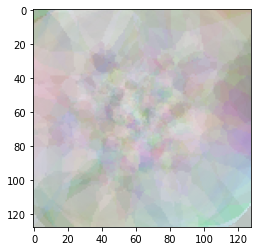

In [13]:
plt.imshow(  q_total  )